In [1]:
%reset -f
import sys
sys.path.insert(0,'..')
from wavhandler import *
# from utils_train import train_test_val_split
from pandas.plotting import register_matplotlib_converters
from utils_train import test_inds, test_days
register_matplotlib_converters()
import numpy as np

np.random.seed(42)

W1120 13:52:57.457938 139807970166592 __init__.py:321] Limited tf.compat.v2.summary API due to missing TensorBoard installation.
W1120 13:52:57.531672 139807970166592 __init__.py:321] Limited tf.compat.v2.summary API due to missing TensorBoard installation.
W1120 13:52:57.568414 139807970166592 __init__.py:352] Limited tf.summary API due to missing TensorBoard installation.


In [2]:
data = Dataset('Wingbeats')
print(data.target_classes)

['Ae. aegypti', 'Ae. albopictus', 'An. arabiensis', 'An. gambiae', 'C. pipiens', 'C. quinquefasciatus']


In [3]:
data.read('Ae. aegypti', loadmat=False)
x1 = data.filenames.sample(14800)
data.read('Ae. albopictus', loadmat=False)
x2 = data.filenames.sample(14800)
data.read('An. arabiensis', loadmat=False)
x3 = data.filenames.sample(14800)
data.read('An. gambiae', loadmat=False)
x4 = data.filenames.sample(14800)
data.read('C. pipiens', loadmat=False)
x5 = data.filenames.sample(14800)
data.read('C. quinquefasciatus', loadmat=False)
x6 = data.filenames.sample(14800)

Data: Ae. aegypti.
Read 85553 filenames in 5.28 seconds.
Data: Ae. albopictus.
Read 20231 filenames in 2.27 seconds.
Data: An. arabiensis.
Read 19297 filenames in 2.26 seconds.
Data: An. gambiae.
Read 49471 filenames in 2.26 seconds.
Data: C. pipiens.
Read 30415 filenames in 2.26 seconds.
Data: C. quinquefasciatus.
Read 74599 filenames in 2.26 seconds.


In [4]:
X = pd.concat([x1, x2, x3, x4, x5, x6], axis=0)
y = X.apply(lambda x: x.split('/')[len(BASE_DIR.split('/'))])

In [5]:
from sklearn.preprocessing import LabelEncoder

text_y = y
le = LabelEncoder()
y = le.fit_transform(y.copy())

In [6]:
from sklearn.utils import shuffle
from utils_train import train_test_val_split

X,y = shuffle(X.tolist(),y.tolist(), random_state=0)

X_train, X_test, X_val, y_train, y_test, y_val = train_test_val_split(X,y,test_size=0.13514, val_size=0.2)

In [7]:
keys = pd.Series(le.inverse_transform(y_train)).value_counts().index.tolist()
values = pd.Series(y_train).value_counts().index.tolist()
mapping = dict(zip(keys, values))
print(sorted(mapping.items(), key=lambda x: x[1]))
vcounts = pd.Series(y_train).value_counts()
vcounts.index = mapping.keys()
vcounts

[('Ae. albopictus', 0), ('An. gambiae', 1), ('An. arabiensis', 2), ('Ae. aegypti', 3), ('C. pipiens', 4), ('C. quinquefasciatus', 5)]


C. quinquefasciatus    10240
Ae. aegypti            10240
An. arabiensis         10240
An. gambiae            10240
Ae. albopictus         10240
C. pipiens             10239
dtype: int64

## Modelling

In [8]:
from utils_train import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.utils import to_categorical
from wavhandler import *
import math
from utils_train import TrainConfiguration

In [9]:
traincf = TrainConfiguration(X=X_train, y=y_train)

In [10]:
#model_name='mosquitoes_validation_2' 
#setting='raw'
#top_weights_path = TEMP_DATADIR + str(model_name) + '.h5'
targets = 6
#batch_size = 32

# Build the Neural Network
model = Sequential()

model.add(Conv1D(16, 3, activation='relu', input_shape=(5000, 1)))
model.add(Conv1D(16, 3, activation='relu'))
model.add(BatchNormalization())

model.add(Conv1D(32, 3, activation='relu'))
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling1D(2))
model.add(Conv1D(64, 3, activation='relu'))
model.add(Conv1D(64, 3, activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling1D(2))
model.add(Conv1D(128, 3, activation='relu'))
model.add(Conv1D(128, 3, activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling1D(2))
model.add(Conv1D(256, 3, activation='relu'))
model.add(Conv1D(256, 3, activation='relu'))
model.add(BatchNormalization())
model.add(GlobalAveragePooling1D())

model.add(Dropout(0.5))
model.add(Dense(targets, activation='softmax'))

model.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

callbacks_list = traincf.callbacks_list

In [11]:
model.fit_generator(train_generator(X_train, y_train, batch_size=traincf.batch_size,
                                   target_names=traincf.target_names,
                                   setting=traincf.setting),
                   steps_per_epoch = int(math.ceil(float(len(X_train)) / float(traincf.batch_size))),
                   epochs=traincf.epochs,
                   validation_data = valid_generator(X_val, y_val,
                                                    batch_size=traincf.batch_size,
                                                    target_names=traincf.target_names,
                                                    setting=traincf.setting),
                    validation_steps=int(math.ceil(float(len(X_val))/float(traincf.batch_size))),
                    callbacks = traincf.callbacks_list)

Epoch 1/100
1919/1920 [============================>.] - ETA: 0s - loss: 0.6889 - accuracy: 0.7391
Epoch 00001: val_accuracy improved from -inf to 0.42363, saving model to /home/kalfasyan/projects/wingbeat_frequencies/Jupyter_Notebooks/temp_data/test.h5
1920/1920 [==============================] - 691s 360ms/step - loss: 0.6888 - accuracy: 0.7391 - val_loss: 3.6828 - val_accuracy: 0.4236
Epoch 2/100
1919/1920 [============================>.] - ETA: 0s - loss: 0.4667 - accuracy: 0.8244
Epoch 00002: val_accuracy improved from 0.42363 to 0.60137, saving model to /home/kalfasyan/projects/wingbeat_frequencies/Jupyter_Notebooks/temp_data/test.h5
1920/1920 [==============================] - 524s 273ms/step - loss: 0.4666 - accuracy: 0.8244 - val_loss: 2.1166 - val_accuracy: 0.6014
Epoch 3/100
1919/1920 [============================>.] - ETA: 0s - loss: 0.4118 - accuracy: 0.8454
Epoch 00003: val_accuracy improved from 0.60137 to 0.67331, saving model to /home/kalfasyan/projects/wingbeat_freque

In [12]:
model.load_weights(traincf.top_weights_path)
y_pred = model.predict_generator(valid_generator(X_test, 
                                                    y_test, 
                                                    batch_size=traincf.batch_size, 
                                                    setting=traincf.setting, 
                                                    target_names=traincf.target_names),
        steps = int(math.ceil(float(len(X_test)) / float(traincf.batch_size))))

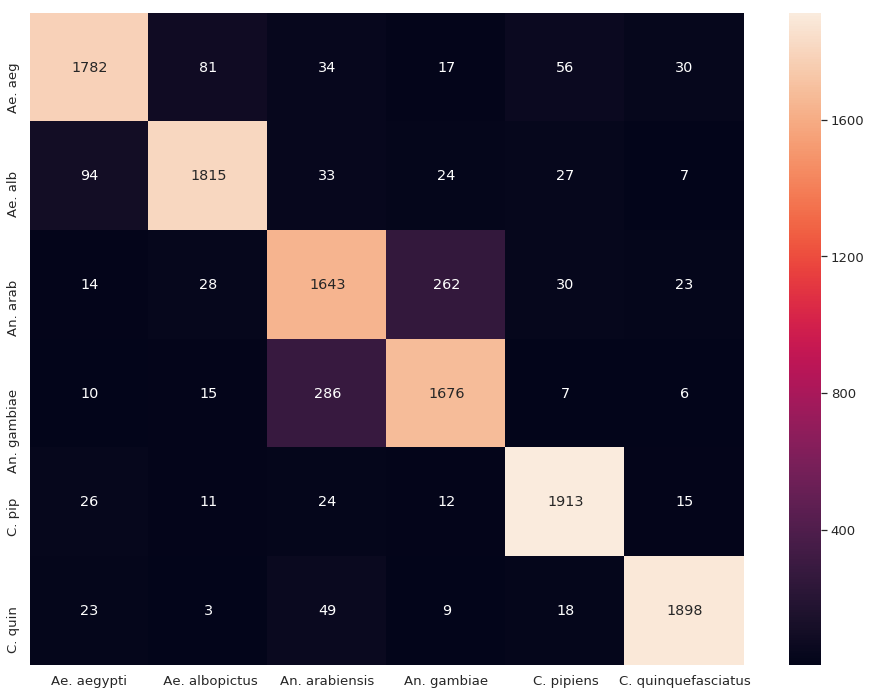

In [13]:
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
x = confusion_matrix(np.array(y_test), np.argmax(y_pred, axis=1))

plt.figure(figsize=(16,12))
sns.set(font_scale=1.2)
ticks = ['Ae. aegypti',' Ae. albopictus','An. arabiensis','An. gambiae','C. pipiens','C. quinquefasciatus']
ticks_short = ['Ae. aeg','Ae. alb','An. arab','An. gambiae','C. pip','C. quin']
sns.heatmap(x, annot=True, fmt='.0f', xticklabels=ticks, yticklabels=ticks_short)

In [14]:
model.load_weights(traincf.top_weights_path)
loss, acc = model.evaluate_generator(valid_generator(X_test, 
                                                    y_test, 
                                                    batch_size=traincf.batch_size, 
                                                    setting=traincf.setting, 
                                                    target_names=traincf.target_names),
        steps = int(math.ceil(float(len(X_test)) / float(traincf.batch_size))))

print('loss', loss)
print('Test accuracy:', acc)

loss 0.40943151832486385
Test accuracy: 0.89384216


In [15]:
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(np.array(y_test), np.argmax(y_pred, axis=1))

0.893836998167583